# Requirements

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

import ast

# 📝 Proyecto Final –  Análisis exploratorio de sentimientos y rendimiento en trailers de películas


### Cargar el dataset


In [5]:
url = "https://raw.githubusercontent.com/JotaNota/YoutubeTrailer_ML/Part_III_Model/data/processed/data_trailer_EDA_I.csv"
df_final = pd.read_csv(url)

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1105 entries, 0 to 1104
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1105 non-null   object 
 1   trailer_link       1105 non-null   object 
 2   sentiment_scores   1105 non-null   object 
 3   favorability       1105 non-null   float64
 4   rating             1104 non-null   object 
 5   genre              1105 non-null   object 
 6   year               1105 non-null   int64  
 7   released           1105 non-null   object 
 8   votes              1105 non-null   float64
 9   director           1105 non-null   object 
 10  writer             1104 non-null   object 
 11  star               1105 non-null   object 
 12  country            1105 non-null   object 
 13  budget             901 non-null    float64
 14  gross              1105 non-null   float64
 15  company            1105 non-null   object 
 16  runtime            1104 

In [6]:
df_final.describe()

,favorability,year,votes,budget,gross,runtime,positive,neutral,negative,total_comments,...,genre_Sci-Fi,genre_Thriller,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,rating_TV-MA,rating_Unrated
count,1105.000000,1105.000000,1.105000e+03,9.010000e+02,1.105000e+03,1104.000000,1105.000000,1105.000000,1105.000000,1105.000000,...,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000
mean,0.679717,2010.043439,1.364592e+05,4.306125e+07,1.060908e+08,109.175725,78.871493,69.002715,38.382805,186.257014,...,0.001810,0.000905,0.005430,0.001810,0.035294,0.082353,0.373756,0.492308,0.002715,0.005430
std,0.132921,6.095252,1.728636e+05,4.692794e+07,1.698105e+08,16.974139,40.382767,36.440081,24.597320,88.328556,...,0.042524,0.030083,0.073521,0.042524,0.184606,0.275026,0.484019,0.500167,0.052058,0.073521
min,0.000000,1980.000000,3.360000e+02,1.500000e+04,1.808000e+03,75.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.610390,2007.000000,3.400000e+04,1.200000e+07,1.060642e+07,96.750000,45.000000,39.000000,18.000000,105.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.689655,2010.000000,7.300000e+04,2.800000e+07,4.473466e+07,106.000000,89.000000,77.000000,38.000000,250.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.760000,2014.000000,1.670000e+05,5.500000e+07,1.258562e+08,118.000000,110.000000,95.000000,54.000000,250.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,2019.000000,1.600000e+06,3.000000e+08,1.236005e+09,193.000000,164.000000,212.000000,127.000000,251.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Paso 2 — Crear la métrica favorability_ratio


#### 📌 Justificación del cálculo de `favorability_ratio` y creación del target

- Se asigna un **peso de 0.25 a los comentarios neutros**.  
- El objetivo es **evitar que los neutros “aplasten” la métrica** e incorporarlos de forma moderada.   
- Esto Evita que tráilers con miles de neutros sean clasificados exitososo cuando tienen pocos positivos o como fallidos con pocos negativos.  
- El resultado es una `favorability_ratio` más útil para modelado supervisado.  
- Le dará mayor impacto a los pocos positivos o negativos.

🔹 **Ejemplo:**  
- 1000 neutros, 10 positivos, 5 negativos → `favorability_ratio ≈ 0.50`  
Si los **neutros valen 0.5** → aplasta la variabilidad y hace que casi todo sea “neutral”.  

- Si los **neutros valen 0.25** → se aplanan los datos y se da mayor peso relativo a positivos y negativos, genera más contraste en la métrica.  


In [7]:
# Cálculo de la métrica con neutral ponderado al 25%
df_final["favorability_ratio"] = (
    df_final["positive"] + 0.25 * df_final["neutral"]
) / (df_final["positive"] + df_final["neutral"] + df_final["negative"])
df_final[["positive", "neutral", "negative", "favorability_ratio"]].head()

,positive,neutral,negative,favorability_ratio
0,87,112,51,0.460000
1,40,45,18,0.497573
2,120,89,41,0.569000
3,93,98,19,0.559524
4,128,97,25,0.609000


#### 2.1 qcut


##### Justificación de `qcut` en la creación del target

¿Por qué usamos `qcut`?
> - `qcut` divide la métrica en **cuantiles balanceados**, generando grupos con tamaños similares.  
> - Esto evita el **desbalance de clases**, es decir, muchos apilados en neutrales.  
> - Con un target más equilibrado, el modelo aprende mejor.
> - Transformar la métrica continua en un **target balanceado**  

¿Qué pasaría sin `qcut`?
> - Si ponemos los intervaloes manualmente, por ejemplo, con cortes arbitrarios, el resultado puede estar muy desbalanceado.  



In [8]:
df_final["favorability_level_3"] = pd.qcut(
    df_final["favorability_ratio"],
    q=3,
    labels=["Baja", "Media", "Alta"]
)

In [9]:
df_final[["favorability_ratio", "favorability_level_3"]].head()


,favorability_ratio,favorability_level_3
0,0.460000,Baja
1,0.497573,Media
2,0.569000,Alta
3,0.559524,Alta
4,0.609000,Alta


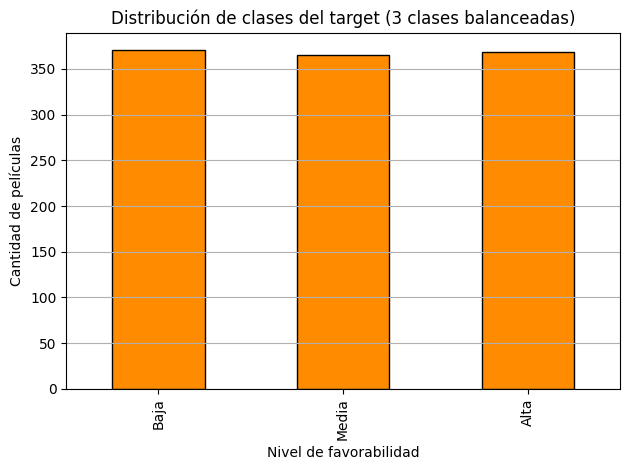

In [10]:
# Revisara si favorability_level_3 para ver si quedaron balanceadas

df_final["favorability_level_3"].value_counts().sort_index().plot(
    kind="bar", color="darkorange", edgecolor="black"
)
plt.title("Distribución de clases del target (3 clases balanceadas)")
plt.xlabel("Nivel de favorabilidad")
plt.ylabel("Cantidad de películas")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [11]:
# Contar cuántas películas hay en cada categoría
df_final["favorability_level_3"].value_counts().sort_index()

,count
favorability_level_3,
Baja,371
Media,365
Alta,369


In [12]:
# Calcular el porcentaje de películas en cada categoría
# Se verifica el balance de ~33% cada una
df_final["favorability_level_3"].value_counts(normalize=True).sort_index() * 100


,proportion
favorability_level_3,
Baja,33.574661
Media,33.031674
Alta,33.393665


## 📌 Reducción de dimensionalidad


In [13]:
df_final.columns

Index(['name', 'trailer_link', 'sentiment_scores', 'favorability', 'rating',
       'genre', 'year', 'released', 'votes', 'director', 'writer', 'star',
       'country', 'budget', 'gross', 'company', 'runtime', 'positive',
       'neutral', 'negative', 'total_comments', 'positive_ratio',
       'emotional_balance', 'genre_Action', 'genre_Adventure',
       'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime',
       'genre_Drama', 'genre_Fantasy', 'genre_Horror', 'genre_Mystery',
       'genre_Romance', 'genre_Sci-Fi', 'genre_Thriller', 'rating_G',
       'rating_NC-17', 'rating_Not Rated', 'rating_PG', 'rating_PG-13',
       'rating_R', 'rating_TV-MA', 'rating_Unrated', 'favorability_ratio',
       'favorability_level_3'],
      dtype='object')

### Chi2


#### Selección de variables con Chi2

¿Por qué usar Chi2?
> - Método para identificar qué variables independiente aportan más información para predecir el target o variable objetivo `favorability_level_3`.     

¿Qué hace Chi2?
> - Calcula un puntaje para cada variable en función de su relación con el target.Seleccionando las variables más útiles para el modelo.
> - Luego ordena las variables de mayor a menor relevancia.   

In [14]:
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.preprocessing import LabelEncoder

# Columnas a excluir
columnas_excluir = [
    'name', 'trailer_link', 'sentiment_scores', 'favorability', 'rating',
    'genre', 'year', 'released', 'director', 'writer', 'star', 'country',
    'company',
    'positive_ratio', 'emotional_balance',  # métricas derivadas
    'favorability_ratio', 'favorability_level_3'  # BASE DEL target
]

# Features (X)
X = df_final.drop(columns=columnas_excluir)

# Aseguramos que no haya negativos -requisito que pidió chi2-
X = X.clip(lower=0)

# Target (y)
y = LabelEncoder().fit_transform(df_final['favorability_level_3'])

print("Shape de X:", X.shape)
print("Ejemplo de features:", X.columns[:10].tolist())
print("Clases del target:", set(y))

Shape de X: (1105, 29)
Ejemplo de features: ['votes', 'budget', 'gross', 'runtime', 'positive', 'neutral', 'negative', 'total_comments', 'genre_Action', 'genre_Adventure']
Clases del target: {np.int64(0), np.int64(1), np.int64(2)}


#### Top 10 features más relevantes según Chi2.


In [15]:
# from sklearn.impute import SimpleImputer

# Imputar valores faltantes con la mediana
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Aplicar SelectKBest con chi2
selector = SelectKBest(score_func=chi2, k=10)
X_new = selector.fit_transform(X_imputed, y)

# Obtener nombres y scores
selected_features = X_imputed.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]

# Mostrar tabla
resultados = pd.DataFrame({
    "Feature": selected_features,
    "Chi2 Score": scores
}).sort_values(by="Chi2 Score", ascending=False)

print("Top 10 features seleccionadas por Chi2:")
print(resultados)


Top 10 features seleccionadas por Chi2:
          Feature    Chi2 Score
2           gross  2.375978e+09
1          budget  4.886943e+08
0           votes  2.082159e+06
6        negative  2.365032e+03
4        positive  1.815697e+03
5         neutral  8.522455e+02
7  total_comments  4.305595e+02
9    genre_Horror  7.059394e+01
3         runtime  3.259291e+01
8    genre_Comedy  2.989541e+01


#### Resultado
El ranking mostró que las variables más predictivas fueron cuantitativas y sentimentales:  
- `gross`, `budget`, `votes`  
- `positive`, `negative`, `neutral`, `total_comments`  
- `runtime`  

#### Justificación: exclusión de variables de género

Chi2 arrojó 2 géneros `genre_Horror`, `genre_Comedy`, pero:
- Si quisiéramos hacer un análisis de género, deberíamos hacerlo con **todos**
- Incluirlos podría afectar el modelo.  

Decisión:
- Por estas razones, **excluí las variables de género** y dejé **8 features principales** para entrenar el modelo.  


In [16]:
# Convertir a lista para poder modificar
selected_features = list(selected_features)

# Quitar Horror y Comedy
for col in ["genre_Horror", "genre_Comedy"]:
    if col in selected_features:
        selected_features.remove(col)

print("Cantidad de features finales:", len(selected_features))
print("Features finales (sin Horror ni Comedy):", selected_features)

# Crear dataset final con esas variabless
X_final = X_imputed[selected_features]
y_final = y

print("Shape de X_final:", X_final.shape)
print("Shape de y_final:", y_final.shape)
print("Hay NaN en y_final?", X_final.isna().sum().sum() > 0)
print("Hay NaN en X_final?", X_final.isna().sum().sum() > 0)

Cantidad de features finales: 8
Features finales (sin Horror ni Comedy): ['votes', 'budget', 'gross', 'runtime', 'positive', 'neutral', 'negative', 'total_comments']
Shape de X_final: (1105, 8)
Shape de y_final: (1105,)
Hay NaN en y_final? False
Hay NaN en X_final? False


### ANOVA


#### Selección de variables con ANOVA F-test

> ¿Por qué usar ANOVA?
- Al ser target es **categórico**,  **ANOVA F-test** analiza si alguna variable independiente, tiene valores medios diferentes según el grupo del target, en este caso: bajo, medio, alto.

> ¿Cómo funciona?
- Compara el cambio de los valores dentro de cada grupo del target
- Si la diferencia entre los grupos es grande, el F-score será alto, lo que significa que esa variable ayuda a distinguir las clases.

In [17]:
# from sklearn.feature_selection import SelectKBest, f_classif

# Aplicar SelectKBest con ANOVA F-test
selector_anova = SelectKBest(score_func=f_classif, k=10)
X_new_anova = selector_anova.fit_transform(X_imputed, y)

# Obtener nombres y scores
selected_features_anova = X_imputed.columns[selector_anova.get_support()]
scores_anova = selector_anova.scores_[selector_anova.get_support()]

# Mostrar en tabla
resultados_anova = pd.DataFrame({
    "Feature": selected_features_anova,
    "F Score": scores_anova
}).sort_values(by="F Score", ascending=False)

print("Top 10 features seleccionadas por ANOVA F-test:")
print(resultados_anova)


Top 10 features seleccionadas por ANOVA F-test:
          Feature    F Score
5        negative  86.659915
3        positive  47.615730
9    genre_Horror  40.458720
4         neutral  23.026895
8    genre_Comedy  20.308564
7    genre_Action  11.326618
2         runtime   6.238993
1          budget   5.423054
6  total_comments   5.178316
0           votes   4.786842


#### Resultado
> El ranking ANOVA mostró como más relevantes:  
- Variables sentimentales: `negative`, `positive`, `neutral`.  
- Género `Horror`, `Comedy`, `Action`.  
- Otras cuantitativas: `runtime`, `budget`, `votes`, `total_comments`.

> Interpretación
- Confirma la importancia de los **comentarios de sentiemiento positivo, negativo**.  
- El algoritmo también selecciona algunos géneros específicos, lo cual refleja que en este dataset ciertos géneros tienen diferencias notorias en la distribución de favorabilidad.  

> Decisión
- Al igual que con Chi2, **no incluiremos las variables de género**.
- Nos quedaremos con las variables relevantes `negative`, `positive`, `neutral`, `runtime`, `budget`, `votes`, `total_comments`.

## 2)📌 Escoger un algoritmo e regresión o clasificación


## paso 1 - Preparación del dataset final
Construcción del dataset  para el modelo:  
- Se eliminan las variables de género para evitar sesgos.  
- Se seleccionan solo las features relevantes sentimentales y cuantitativas.  
- Se arma la matriz final (`X_final`, `y_final`) y se verifica que no haya valores nulos.


In [18]:
# Definir features finales eliminando cualquier género
selected_features = [f for f in selected_features if not f.startswith("genre_")]

# Dataset final
X_final = X_imputed[selected_features]
y_final = y  # ya estaba codificado con LabelEncoder

print("Features finales usadas en el modelo:", selected_features)
print("Shape de X_final:", X_final.shape)
print("Shape de y_final:", y_final.shape)
print("¿Hay NaN en X_final?", X_final.isna().sum().sum() > 0)
print("¿Hay NaN en y_final?", pd.isna(y_final).sum() > 0)


Features finales usadas en el modelo: ['votes', 'budget', 'gross', 'runtime', 'positive', 'neutral', 'negative', 'total_comments']
Shape de X_final: (1105, 8)
Shape de y_final: (1105,)
¿Hay NaN en X_final? False
¿Hay NaN en y_final? False


## Paso 2 Selección del algoritmo

En esta parte se prueban tres algoritmos:

1. **Árbol de Decisión** → Sencillo e interpretable.  
2. **Regresión Logística** → Baseline clásico en problemas de clasificación.  
3. **Random Forest** → Modelo más robusto, que combina múltiples árboles.  

Se espera que La comparación de sus resultados permita identificar el modelo con mejor desempeño para predecir la favorabilidad.



### ⚙️ Modelo 1: Árbol de Decisión


In [19]:
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dividir datos en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.3, random_state=42, stratify=y_final
)

# Crear y entrenar Árbol de Decisión
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

# Predicciones
y_pred = dt_model.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7048192771084337

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73       111
           1       0.71      0.77      0.74       111
           2       0.69      0.60      0.64       110

    accuracy                           0.70       332
   macro avg       0.70      0.70      0.70       332
weighted avg       0.70      0.70      0.70       332


Matriz de confusión:
 [[83 16 12]
 [ 9 85 17]
 [25 19 66]]


#### **Resultado de Árbol de Decisión**

> - **Accuracy** 0.70, 70% de predicciones correctas en general.  
> - las clases de macro avg y Weighted avg estan balanceadas.
> - **Clase 2 alta** → recall = 0.60, problemas al predecir. El modelo solo detecta 6 de cada 10 tráilers realmente ‘altos’
> - **Matriz de confusión** → En clase 2 se observan más errores.

♦ **Matriz de confusión:**
**Aciertos por clase**:
> - Baja → 83/111 ≈ 75% correctos.
> - Media → 85/111 ≈ 77% correctos.
> - Alta → 66/110 ≈ 60% correctos.

**♦ Errores más comunes:**
> - La clase alta se confunde mucho con baja y media.
> - Las clases baja y media se predicen mejor y con menos confusiones.

♦ **Interpretación:**
> - El modelo logra separar bien baja y media, pero tiene más problemas para identificar la clase alta.

### ⚙️ Modelo 2: Regresión Logística


In [20]:
#from sklearn.linear_model import LogisticRegression

# Crear y entrenar RL
log_model = LogisticRegression(max_iter=1000, random_state=42, multi_class="multinomial")
log_model.fit(X_train, y_train)

# Predicciones
y_pred_log = log_model.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred_log))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.7319277108433735

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.81      0.72       111
           1       0.88      0.75      0.81       111
           2       0.71      0.64      0.67       110

    accuracy                           0.73       332
   macro avg       0.75      0.73      0.73       332
weighted avg       0.75      0.73      0.73       332


Matriz de confusión:
 [[90  0 21]
 [21 83  7]
 [29 11 70]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Ajuste de la Regresión Logística
-Al entrenar la regresión logística apareció un aviso de que **el modelo no alcanzó a converger** en el número de iteraciones.  
- Para solucionarlo aumenté el número de iteraciones `max_iter`.  
- Esto, parece, le permite ajustarse mejor.


In [21]:
# from sklearn.linear_model import LogisticRegression

# Crear y entrenar RL con datos imputados
log_model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred_log))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8433734939759037

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92       111
           1       0.80      0.93      0.86       111
           2       0.86      0.65      0.74       110

    accuracy                           0.84       332
   macro avg       0.85      0.84      0.84       332
weighted avg       0.85      0.84      0.84       332


Matriz de confusión:
 [[106   1   4]
 [  0 103   8]
 [ 14  25  71]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Resultado de Regresión Logística

Se evaluó la regresión logística con dos configuraciones de iteraciones `max_iter`:  

- **Con 1000 iteraciones**  
  - **Accuracy ≈ 0.73**.  
  - **Macro avg y Weighted avg ≈ 0.73**.  
  - **Clase 0 baja ** → recall = 0.81 → detecta bien.  
  - **Clase 1 media** → precisión = 0.88, pero recall = 0.75.  
  - **Clase 2 alta ** → recall = 0.64 → sigue siendo la más difícil de identificar.  

- **Con 5000 iteraciones**  
  - **Accuracy ≈ 0.84** → mejora en desempeño.  
  - Clases baja y media alcanzan recalls muy altos (0.95 y 0.93).  
  - La clase alta sube un poco pero sigue siendo la más débil recall = 0.65.  

- ♦ **Matriz de confusión - con 5000 iteraciones:**  
  - Baja → 106/111 ≈ 95% correctos.  
  - Media → 103/111 ≈ 93% correctos.  
  - Alta → 71/110 ≈ 65% correctos.  

**Interpretación:**  
> - Al aumentar iteraciones, el modelo mejora bastante, de 0.73 → 0.84 de accuracy.  
> - La clase alta sigue siendo la más difícil, aunque con leve mejora.  
> - Aparecen advertencias de convergencia que no termino de resolver, pero los resultados muestran la diferencia entre configuraciones.


###⚙️ Modelo 3: Random Forest


In [22]:
# from sklearn.ensemble import RandomForestClassifier

# Crear y entrenar RF
rf_model = RandomForestClassifier(
    n_estimators=100,   # número de árboles
    max_depth=None,     # sin límite de profundidad
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.8042168674698795

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       111
           1       0.80      0.82      0.81       111
           2       0.77      0.72      0.75       110

    accuracy                           0.80       332
   macro avg       0.80      0.80      0.80       332
weighted avg       0.80      0.80      0.80       332


Matriz de confusión:
 [[97  6  8]
 [ 5 91 15]
 [14 17 79]]


#### ► Resultado de Random Forest

> - **Accuracy 0.80**.  
> - **Macro avg y Weighted avg = 0.80** → desempeño consistente entre clases.  
> - **Clase 0 ** → recall = 0.87, el modelo detecta muy bien los tráilers con baja favorabilidad.
> - **Clase 1** → precisión = 0.80 y recall = 0.82.  
> - **Clase 2 ** → recall = 0.72 → mejora frente a los otros modelos, aunque sigue siendo la más difícil de predecir.

- ♦ **Matriz de confusión:**  
  - Baja → 97/111 ≈ 87% correctos.  
  - Media → 91/111 ≈ 82% correctos.  
  - Alta → 79/110 ≈ 72% correctos.  

- ♦ RandomForest vs Regresión logistica (5000mil itereacions)
  - **Regresión Logística 5000 iteraciones:** mejor accuracy global **0.84 vs 0.80**, pero con desequilibrio entre clases → baja y media lo hace muy bien, alta es floja.  
  - **Random Forest:** menor accuracy global, pero más balanceado → no llega al 0.95 de recall en baja/media, pero es mas preciso en alta.  

- Interpretación:
  - **Random Forest** ofrece un rendimiento más equilibrado entre las clases.

---



##📌 Metricas

### Comparación de métricas entre modelos

- Se presentan las métricas de desempeño del Random Forest, junto con su matriz de confusión visualizada.

In [23]:
# Resultados obtenidos manualmente de cada modelo
resultados = pd.DataFrame({
    "Modelo": ["Árbol de Decisión", "Regresión Logística", "Random Forest"],
    "Accuracy": [0.70, 0.73, 0.80],
    "F1 Baja": [0.73, 0.72, 0.85],
    "F1 Media": [0.74, 0.81, 0.81],
    "F1 Alta": [0.64, 0.67, 0.75]
})

print(resultados)

                Modelo  Accuracy  F1 Baja  F1 Media  F1 Alta
0    Árbol de Decisión      0.70     0.73      0.74     0.64
1  Regresión Logística      0.73     0.72      0.81     0.67
2        Random Forest      0.80     0.85      0.81     0.75


### Accuracy
% de predicciones correctas sobre el total.

In [24]:
# from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7048192771084337


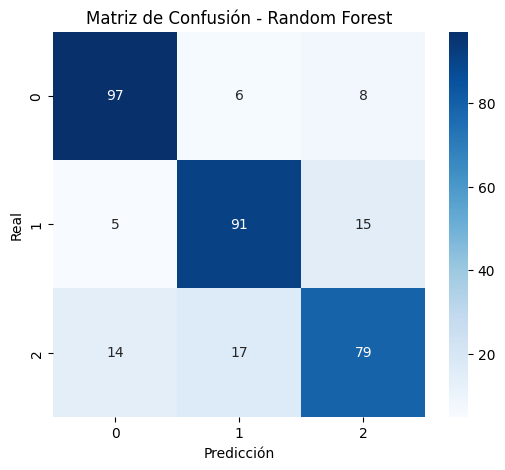

In [25]:
cm = confusion_matrix(y_test, y_pred_rf)
labels = np.unique(y_test)   # es para el orden correcto de las clases

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# 📌 Conclusiones

- Al inicio exploramos variables como los géneros de películas, pero al aplicar reducción de dimensionalidad las variables más relevantes resultaron ser otras características del dataset.  
>
> - En la **Parte II EDA** se exploraron variables como género y presupuesto para generar hipótesis y contexto de negocio.  
> - En la **Parte III ML**, el objetivo es predecir la favorabilidad `favorability_level_3`.


- Se entrenaron tres clasificadores: **Árbol de Decisión, Regresión Logística y Random Forest**.  
- El mejor rendimiento lo tuvo **Random Forest**, con un buen balance entre *precision* y *recall*, y un **accuracy cercano al 80%**.  

---

►  Este proyecto fue un ejercicio exploratorio para aplicar Machine Learning en un dataset de trailers.  
- El objetivo fue:
> → Experimentar con selección de variables, entrenar modelos y evaluar.  
